# <b>Data Science Prjoect: Influences on Covid Vaccination Rates</b>

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
# Helpers

# Create c_map
codes = pd.read_csv('datasets/country_codes.csv')

lookup_table = codes[['Alpha-3 code','Country']]

# Lookup table to dict
c_map = {}
for i, t in lookup_table.iterrows():
    key = t[0][2:5]
    val = t[1]
    
    c_map[key] = val

## 1. Load and Clean Data 
In the first step we need to load and clean our data. We load each CSV file and extreact the desired feature. Then we convert it to the ight format and finally create a merged dataframe.

In [3]:
vax_rates = pd.read_csv('datasets/COVID-19_vaccination_rates.csv') 
vax_rates = vax_rates.loc[(vax_rates["date"]=="2021-10-25")]
vax_rates = vax_rates[["location","people_fully_vaccinated_per_hundred"]]
vax_rates.rename(columns={'location': 'Country Name'}, inplace=True)
vax_rates = vax_rates.loc[(vax_rates["people_fully_vaccinated_per_hundred"]==vax_rates["people_fully_vaccinated_per_hundred"])]

In [4]:
trust_in_gov = pd.read_csv('datasets/trust_in_government.csv') 
    
# enhance government trust df
trust_in_gov = trust_in_gov.assign(country=trust_in_gov['LOCATION'].map(c_map))
 
trust_in_gov = trust_in_gov.loc[(trust_in_gov["TIME"]==2019)][["country","Value"]]
trust_in_gov.rename(columns={"Value": "trust_in_government_2019"}, inplace=True)
trust_in_gov.rename(columns={"country": "Country Name"}, inplace=True)

In [5]:
gdp = pd.read_csv('datasets/gdp_per_capita.csv') 
gdp = gdp[["Country Name","2020"]]
gdp.rename(columns={'2020': 'gdp_per_capita_2020'}, inplace=True)
gdp = gdp.loc[(gdp["gdp_per_capita_2020"]==gdp["gdp_per_capita_2020"])]
gdp = gdp.set_index('Country Name')

In [6]:
secondary_edu = pd.read_csv('datasets/secondary_education.csv')  
secondary_edu = secondary_edu.loc[(secondary_edu["TIME"]==2019)].loc[(secondary_edu["SUBJECT"]=="UPPSRY")][["LOCATION","Value"]]
secondary_edu.rename(columns={"Value": "secondary_education_2019"}, inplace=True)
        
# enhance government trust df
secondary_edu = secondary_edu.assign(country=secondary_edu['LOCATION'].map(c_map))
secondary_edu = secondary_edu[['country', 'secondary_education_2019']]
secondary_edu.rename(columns={"country": "Country Name"}, inplace=True)

secondary_edu = secondary_edu.dropna()

In [7]:
tert_edu = pd.read_csv('datasets/tertiary_education.csv')[["LOCATION","SUBJECT", "TIME", "Value"]]
tert_edu = tert_edu.loc[(tert_edu["TIME"]==2019)].loc[(tert_edu["SUBJECT"]=="BACHR_MEN")|(tert_edu["SUBJECT"]=="BACHR_WOMEN")]
tert_edu.rename(columns={"Value": "tertiary_education_2019"}, inplace=True)

tert_edu = tert_edu.pivot(index="LOCATION", columns="SUBJECT", values="tertiary_education_2019")
tert_edu['tertiary_education_2019'] = tert_edu["BACHR_MEN"] + tert_edu['BACHR_WOMEN']
tert_edu = tert_edu["tertiary_education_2019"].to_frame()
tert_edu = tert_edu.reset_index() 
        
# enhance government trust df
tert_edu = tert_edu.assign(country=tert_edu['LOCATION'].map(c_map))
tert_edu.rename(columns={"country": "Country Name"}, inplace=True)

tert_edu = tert_edu[['Country Name', 'tertiary_education_2019']]

In [8]:
cov_data = pd.read_csv('datasets/worldwide_covid_data.csv')
cov_deaths = cov_data.rename(columns={'Country':'location'})[['location','Deaths/1M population']]
cov_deaths.rename(columns={"location": "Country Name"}, inplace=True)

In [9]:
betterlife = pd.read_csv('datasets/betterlifeindex_2019.csv')

health = betterlife 
health.rename(columns={"Country": "Country Name"}, inplace=True)
health = health[["LOCATION", "Country Name","Indicator", "Value"]].loc[(health["Inequality"]=="Total")]
health = health.loc[(health["Indicator"]=="Self-reported health")][["Country Name", "Value"]]
health.rename(columns={"Value": "Self-reported_health_2019"}, inplace=True)

In [10]:
life_exp = betterlife.loc[(betterlife["Indicator"]=="Life expectancy")][["Country Name", "LOCATION", "Value"]]
life_exp.rename(columns={"Value": "Life_expectancy_2019"}, inplace=True)
life_exp = life_exp[['Life_expectancy_2019', 'Country Name']].groupby('Country Name').max()

In [11]:
work = betterlife.loc[(betterlife["Indicator"]=="Employees working very long hours")][["Country Name", "LOCATION", "Value"]]
work.rename(columns={"Value": "Employees_working_hours_2019"}, inplace=True)
work = work[['Country Name','Employees_working_hours_2019']].groupby('Country Name').max()

In [12]:
unemp = pd.read_csv('datasets/unemployment_rate.csv') 
unemp = unemp[["Country Name","2020"]] # select and reduce
unemp.rename(columns={"2020": "unemployment_2020"}, inplace=True)
unemp = unemp.loc[(unemp["unemployment_2020"]==unemp["unemployment_2020"])]

In [13]:
# merge dataframes
data_frames = [vax_rates, trust_in_gov, gdp, secondary_edu, tert_edu, cov_deaths, health, life_exp, work, unemp]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Country Name'],how='outer'), data_frames)  

In [14]:
df_merged.describe()

,people_fully_vaccinated_per_hundred,trust_in_government_2019,gdp_per_capita_2020,secondary_education_2019,tertiary_education_2019,Deaths/1M population,Self-reported_health_2019,Life_expectancy_2019,Employees_working_hours_2019,unemployment_2020
count,122.000000,40.000000,237.000000,35.000000,28.000000,196.000000,38.000000,41.000000,39.000000,235.000000
mean,47.481393,45.839664,20306.075206,79.886143,61.746821,927.545918,66.868421,82.358537,10.898462,7.981232
std,23.916131,14.586554,20673.099968,8.768683,16.943535,970.235426,14.092687,4.341945,9.509672,4.890636
min,0.040000,15.252345,770.876072,53.251000,11.467000,3.000000,33.000000,59.500000,0.230000,0.310000
25%,31.257500,36.653301,5019.085683,76.586500,53.199750,114.500000,60.000000,81.100000,4.955000,4.635000
50%,52.575000,45.283193,13307.156607,80.510000,64.043500,628.000000,69.000000,83.500000,8.250000,6.790000
75%,64.970000,55.227595,28113.736584,84.862500,73.451250,1587.250000,75.750000,84.300000,15.255000,10.190000
max,118.140000,80.661271,118503.551005,95.814000,91.839000,5967.000000,88.000000,87.100000,36.010000,28.740000


## 2. Analyse vaccination rate with each of the other factors
In the second step we visualize each feature seperately. We calculate correlation and and p-value for each one and visualize the relationship by fitting a regression line.

### Trust in Government

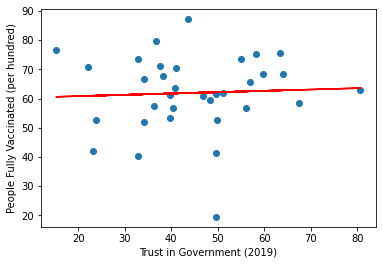

r: 0.048767262127107046
Correlation Coefficient and p-Value
(0.048767262127107074, 0.7841720802236305)


In [15]:
trust_x_vax = pd.merge(trust_in_gov, vax_rates, on=["Country Name"])
trust_x_vax_r = trust_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = trust_x_vax['trust_in_government_2019'].values.reshape(-1, 1)
Y =  trust_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Trust in Government (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()
print("r: {}".format(trust_x_vax_r))
print("Correlation Coefficient and p-Value")
print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

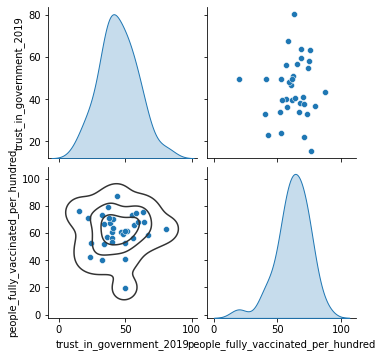

In [16]:
g = sns.pairplot(trust_x_vax, diag_kind="kde")  
g.map_lower(sns.kdeplot, levels=4, color=".2")

### GDP

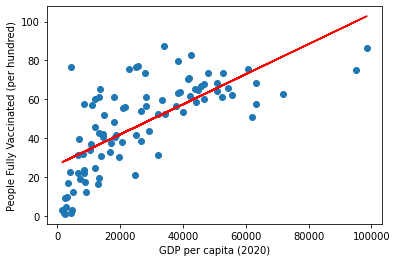

r: 0.700679318365277
Correlation Coefficient and p-Value
(0.7006793183652773, 7.542031256159133e-15)


In [17]:
gdp_x_vax = pd.merge(gdp, vax_rates, on=["Country Name"])
gdp_x_vax_r = gdp_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = gdp_x_vax['gdp_per_capita_2020'].values.reshape(-1, 1)
Y =  gdp_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('GDP per capita (2020)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()
print("r: {}".format(gdp_x_vax_r))
print("Correlation Coefficient and p-Value")
print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

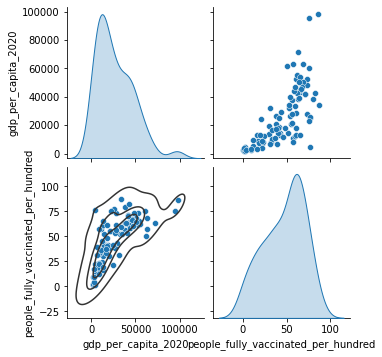

In [18]:
g = sns.pairplot(gdp_x_vax, diag_kind="kde")      
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Secondary Education

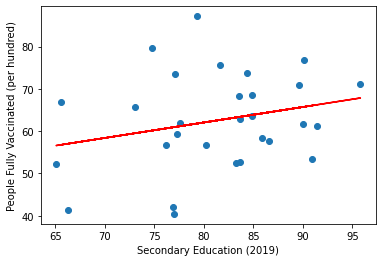

r: 0.24994288969897402
Correlation Coefficient and p-Value
(0.24994288969897396, 0.19099301978906152)


In [19]:
edu2_x_vax = pd.merge(secondary_edu, vax_rates, on=["Country Name"])
edu2_x_vax_r = edu2_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = edu2_x_vax['secondary_education_2019'].values.reshape(-1, 1)
Y =  edu2_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Secondary Education (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()


print("r: {}".format(edu2_x_vax_r))
print("Correlation Coefficient and p-Value")
print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

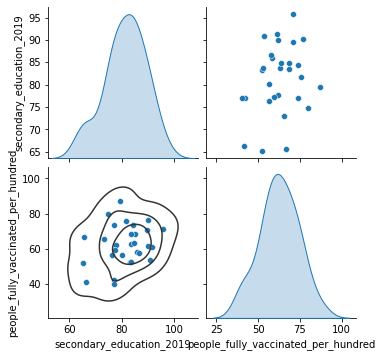

In [20]:
g = sns.pairplot(edu2_x_vax, diag_kind="kde")       
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Tertiary Education

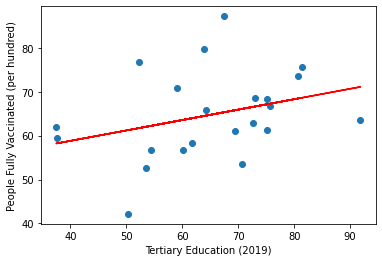

r: 0.24994288969897402
Correlation Coefficient and p-Value
(0.320275896778003, 0.14618472314374167)


In [21]:
edu3_x_vax = pd.merge(tert_edu, vax_rates, on=["Country Name"])
edu3_x_vax_r = edu3_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = edu3_x_vax['tertiary_education_2019'].values.reshape(-1, 1)
Y =  edu3_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Tertiary Education (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()

print("r: {}".format(edu2_x_vax_r))
print("Correlation Coefficient and p-Value")
print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

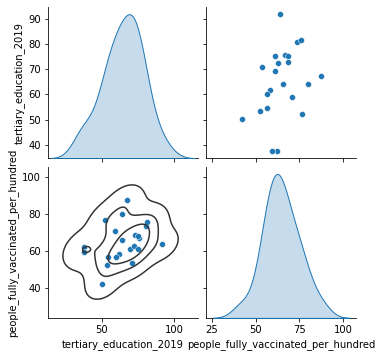

In [22]:
g = sns.pairplot(edu3_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Covid Deaths

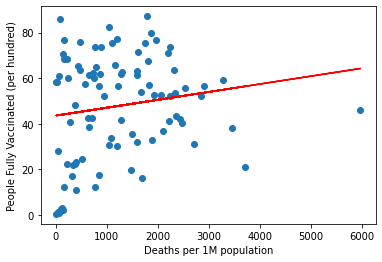

r: 0.15921201241982452
Correlation Coefficient and p-Value
(0.1592120124198245, 0.13390397233263593)


In [23]:
deaths_x_vax = pd.merge(cov_deaths, vax_rates, on=["Country Name"])
deaths_x_vax_r = deaths_x_vax.corr().iloc[0,1]


linear_regressor = LinearRegression()  # create object for the class
X = deaths_x_vax['Deaths/1M population'].values.reshape(-1, 1)
Y =  deaths_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Deaths per 1M population')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()


print("r: {}".format(deaths_x_vax_r))
print("Correlation Coefficient and p-Value")
print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

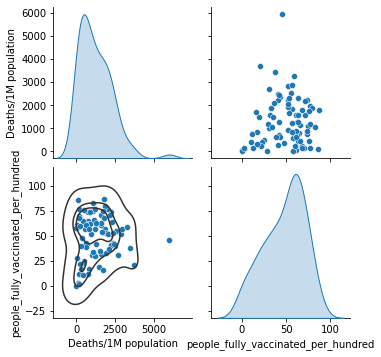

In [24]:
g = sns.pairplot(deaths_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Self Reported Health

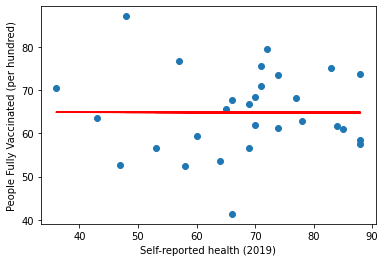

r: -0.001801243803388513
Correlation Coefficient and p-Value
(-0.0018012438033885199, 0.9926010814764531)


In [25]:
health_x_vax = pd.merge(health, vax_rates, on=["Country Name"])
health_x_vax_r = health_x_vax.corr().iloc[0,1]


linear_regressor = LinearRegression()  # create object for the class
X = health_x_vax['Self-reported_health_2019'].values.reshape(-1, 1)
Y =  health_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Self-reported health (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()

print("r: {}".format(health_x_vax_r))
print("Correlation Coefficient and p-Value")
print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

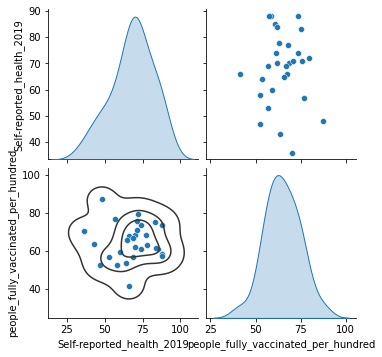

In [26]:
g = sns.pairplot(health_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Life Expectancy

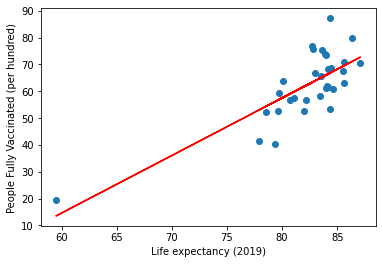

r: 0.7815731285293231
Correlation Coefficient and p-Value
(0.7815731285293231, 1.288725407220812e-07)


In [27]:
life_exp_x_vax = pd.merge(life_exp, vax_rates, on=["Country Name"])
life_exp_x_vax_r = life_exp_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = life_exp_x_vax['Life_expectancy_2019'].values.reshape(-1, 1)
Y =  life_exp_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Life expectancy (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()

print("r: {}".format(life_exp_x_vax_r))
print("Correlation Coefficient and p-Value")
print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

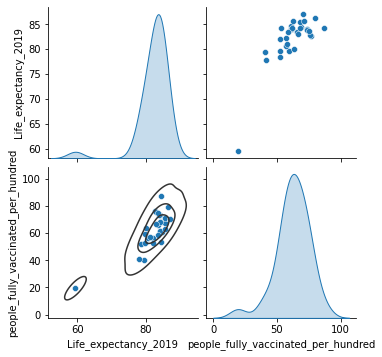

In [28]:
g = sns.pairplot(life_exp_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Working Hours

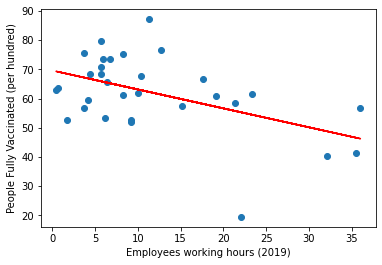

r: -0.482313780615869
Correlation Coefficient and p-Value
(-0.4823137806158691, 0.005999820173321409)


In [29]:
work_x_vax = pd.merge(work, vax_rates, on=["Country Name"])
work_x_vax_r = work_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = work_x_vax['Employees_working_hours_2019'].values.reshape(-1, 1)
Y =  work_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Employees working hours (2019)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()

print("r: {}".format(work_x_vax_r))
print("Correlation Coefficient and p-Value")
print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

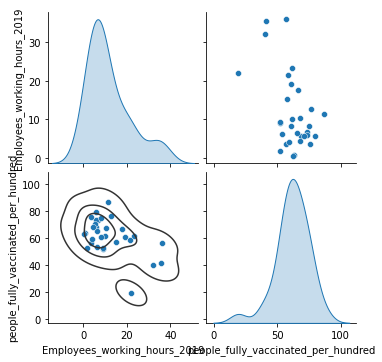

In [30]:
g = sns.pairplot(work_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Unemployment Rate

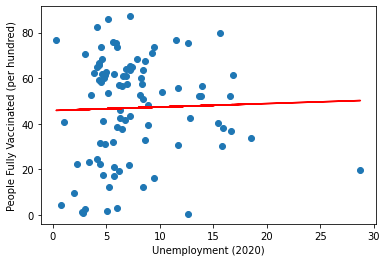

r: 0.030435560053394515
Correlation Coefficient and p-Value
(0.03043556005339452, 0.772116629483641)


In [31]:
unemp_x_vax = pd.merge(unemp, vax_rates, on=["Country Name"])
unemp_x_vax_r = unemp_x_vax.corr().iloc[0,1]

linear_regressor = LinearRegression()  # create object for the class
X = unemp_x_vax['unemployment_2020'].values.reshape(-1, 1)
Y =  unemp_x_vax['people_fully_vaccinated_per_hundred'].values.reshape(-1, 1)
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Unemployment (2020)')
plt.ylabel('People Fully Vaccinated (per hundred)')
plt.show()


print("r: {}".format(unemp_x_vax_r))
print("Correlation Coefficient and p-Value")
print(scipy.stats.pearsonr(X.flatten(), Y.flatten()))

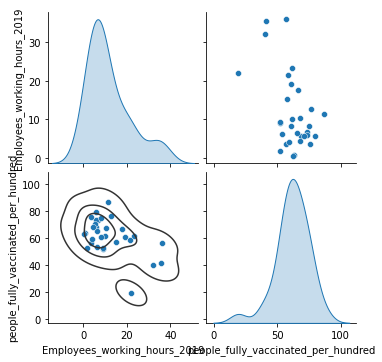

In [32]:
g = sns.pairplot(work_x_vax, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

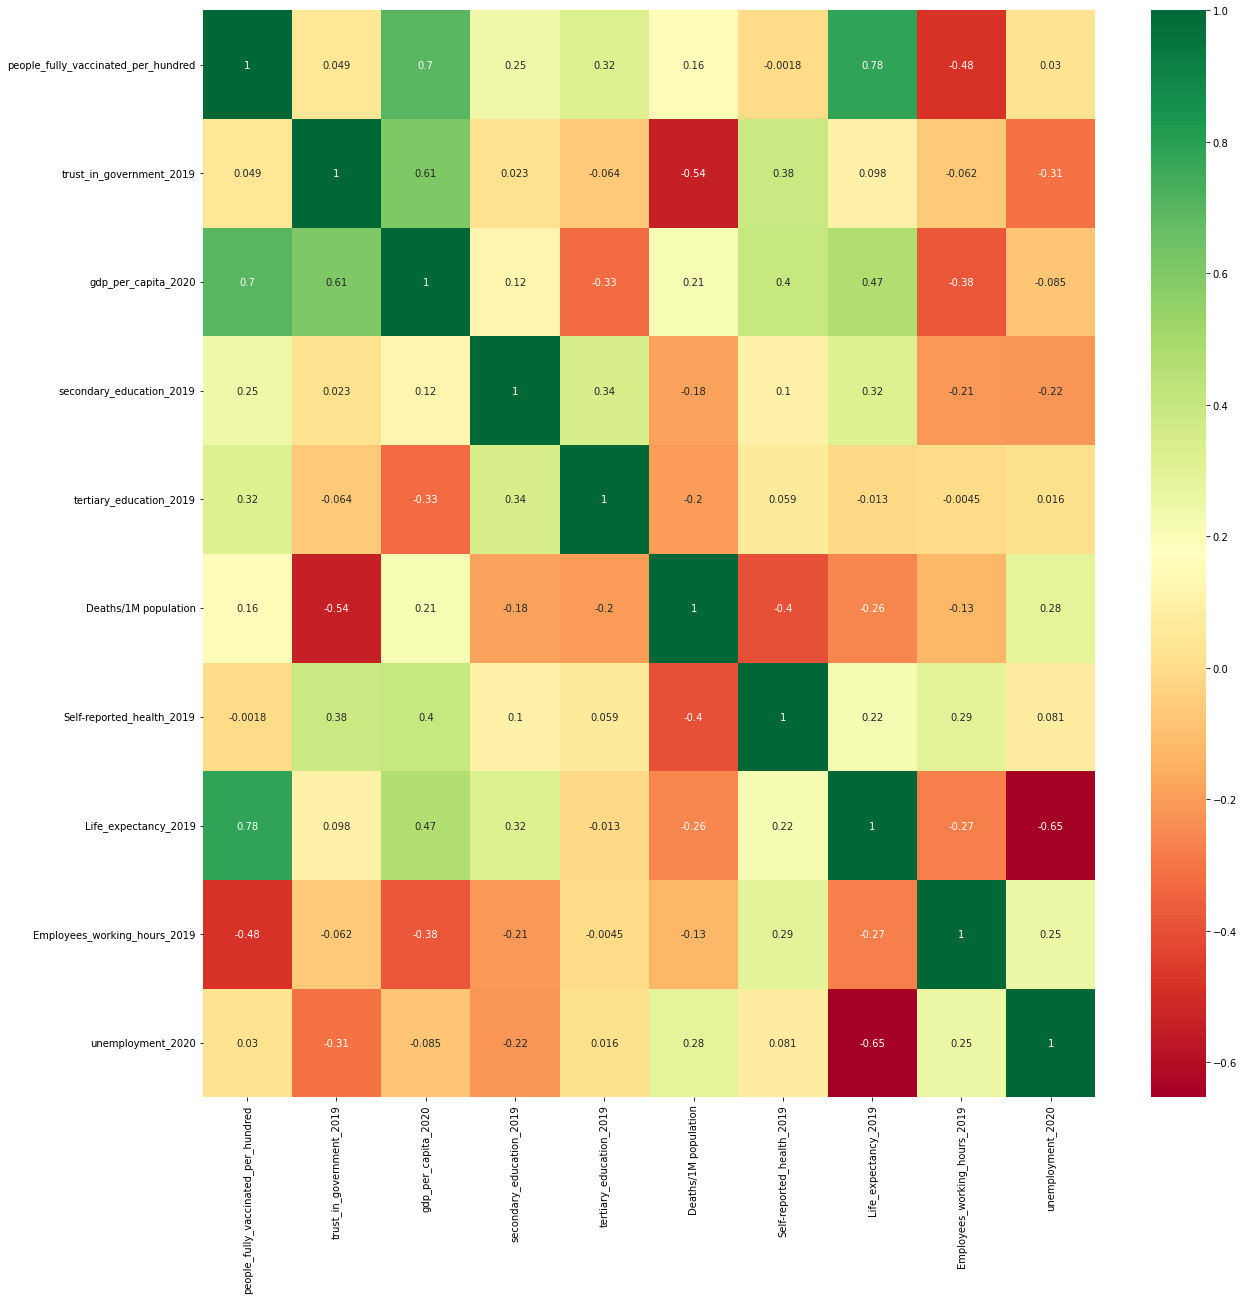

In [33]:
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_merged.corr(),annot=True,cmap="RdYlGn")

In [34]:
# plot all
#https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot

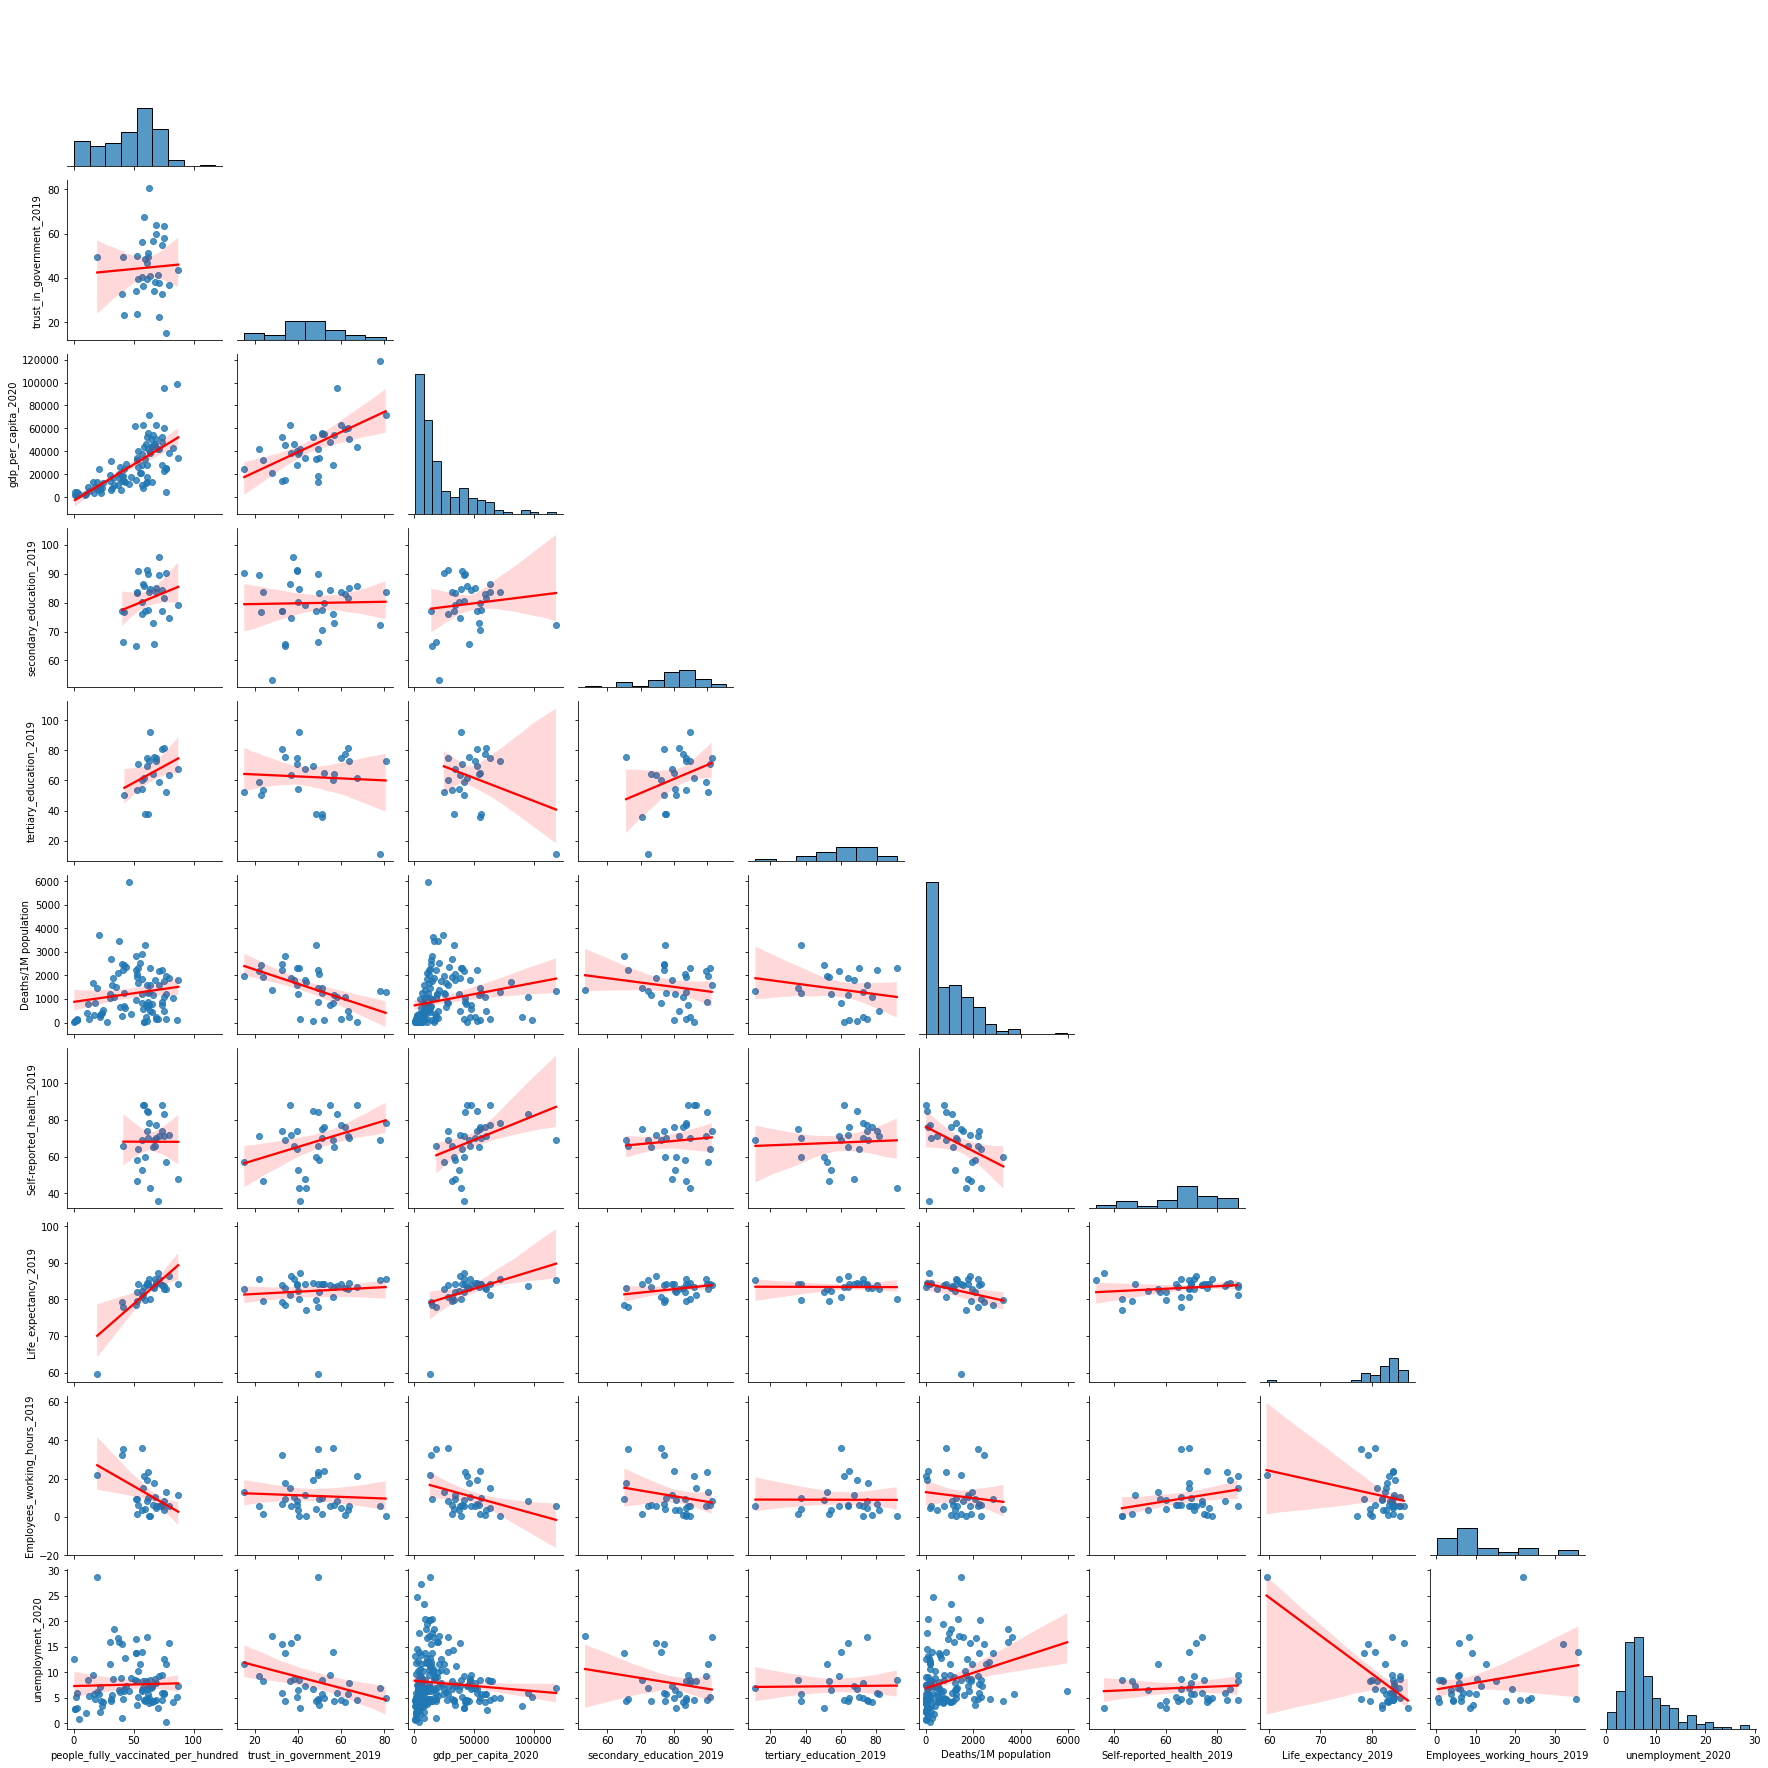

In [35]:
g = sns.pairplot(df_merged, kind="reg", corner=True, plot_kws={'line_kws':{'color':'red'}})
plt.show()